Q2.Machine Learning on Sensor Dataset

2.3 Data Pre-processing Techniques

In [ ]:
import pandas as pd
from google.colab import files

#Upload file
uploaded = files.upload()

#get the uploaded filename automatically
filename = list(uploaded.keys())[0]

#load the CSV file into pandas
df = pd.read_csv(filename)
print("File name:",filename)

#display the 1st few rows and shape
print("Initial Shape: ",df.shape)
display(df.head())

Saving TrafficMonitoringDataset_Q2.csv to TrafficMonitoringDataset_Q2 (3).csv
File name: TrafficMonitoringDataset_Q2 (3).csv
Initial Shape:  (48423, 13)


,time_from,time_to,countline_id,name,car,bus,cyclist,motorbike,pedestrian,rigid,time_bucket,day,total_count
0,2024-01-01 00:00:00+00,2024-01-02 00:00:00+00,52455,Padestrian Path,0,0,0,0,0,0,5min,0,0
1,2024-01-01 00:00:00+00,2024-01-02 00:00:00+00,52454,Inbound_Traffic,0,0,0,0,0,0,5min,0,0
2,2024-01-01 00:00:00+00,2024-01-02 00:00:00+00,52453,Outbound_Traffic,0,0,0,0,0,0,5min,0,0
3,2024-01-01 00:00:00+00,2024-01-01 01:00:00+00,52455,Padestrian Path,0,0,0,0,0,0,5min,0,0
4,2024-01-01 00:00:00+00,2024-01-01 01:00:00+00,52454,Inbound_Traffic,0,0,0,0,0,0,5min,0,0


In [ ]:
# check missing values
print("Missing values per column:\n", df.isna().sum())

Missing values per column:
 time_from       0
time_to         0
countline_id    0
name            0
car             0
bus             0
cyclist         0
motorbike       0
pedestrian      0
rigid           0
time_bucket     0
day             0
total_count     0
dtype: int64


In [ ]:
# Drop rows with missing timestamps (time_from/time_to)
df = df.dropna(subset=['time_from' , 'time_to']).copy()

#for numeric sensor counts, fill missing values with 0
numeric_cols = ['car', 'bus', 'cyclist', 'motorbike', 'pedestrian', 'rigid']
for c in numeric_cols:
  if c in df.columns:
    df[c] = df[c].fillna(0).astype(int)

In [ ]:
# Convert timestamps and extract simple time features
df['time_from'] = pd.to_datetime(df['time_from'], utc=True)
df['time_to'] = pd.to_datetime(df['time_to'], utc=True)
df['hour'] = df['time_from'].dt.hour
df['day_of_week'] = df['time_from'].dt.dayofweek #Monday=0 to Sunday=6

df.head()
#df.to_csv("TD1.csv", index=False)

,time_from,time_to,countline_id,name,car,bus,cyclist,motorbike,pedestrian,rigid,time_bucket,day,total_count,hour,day_of_week
0,2024-01-01 00:00:00+00:00,2024-01-02 00:00:00+00:00,52455,Padestrian Path,0,0,0,0,0,0,5min,0,0,0,0
1,2024-01-01 00:00:00+00:00,2024-01-02 00:00:00+00:00,52454,Inbound_Traffic,0,0,0,0,0,0,5min,0,0,0,0
2,2024-01-01 00:00:00+00:00,2024-01-02 00:00:00+00:00,52453,Outbound_Traffic,0,0,0,0,0,0,5min,0,0,0,0
3,2024-01-01 00:00:00+00:00,2024-01-01 01:00:00+00:00,52455,Padestrian Path,0,0,0,0,0,0,5min,0,0,0,0
4,2024-01-01 00:00:00+00:00,2024-01-01 01:00:00+00:00,52454,Inbound_Traffic,0,0,0,0,0,0,5min,0,0,0,0


In [ ]:
# sums a consistency of total_count from category
if set(numeric_cols).issubset(df.columns):
  df['total_count'] = df[numeric_cols].sum(axis=1)
else:
  df['total_count'] = df.get('total_count',0)

# set negatives to 0
for c in numeric_cols:
  if c in df.columns:
    df.loc[df[c] < 0, c] = 0
df['total_count'] = df[numeric_cols].sum(axis=1)

# standardize route names and remove extra dupicates
df['name'] = df['name'].astype(str).str.strip().str.replace('_',' ').str.title()
df = df.drop_duplicates(subset=['time_from','name','time_bucket'], keep='last').copy()

#convert name to numeric by pandas categorical encoding for route type
df['route_code'] = df['name'].astype('category').cat.codes

df.head()

#save the preprocessed dataset to new csv file
df.to_csv("/content/traffic_Data_Processed.csv", index=False)
#files.download("/content/traffic_Data_Processed.csv")


2.4 Train, Test, and Validation Split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

#load the pre-processed file
df = pd.read_csv("/content/traffic_Data_Processed.csv")

print("Dataset shap:", df.shape)
display(df.head())

Dataset shap: (46488, 16)


,time_from,time_to,countline_id,name,car,bus,cyclist,motorbike,pedestrian,rigid,time_bucket,day,total_count,hour,day_of_week,route_code
0,2024-01-01 00:00:00+00:00,2024-01-01 01:00:00+00:00,52455,Padestrian Path,0,0,0,0,0,0,5min,0,0,0,0,2
1,2024-01-01 00:00:00+00:00,2024-01-01 01:00:00+00:00,52454,Inbound Traffic,0,0,0,0,0,0,5min,0,0,0,0,0
2,2024-01-01 00:00:00+00:00,2024-01-01 01:00:00+00:00,52453,Outbound Traffic,0,0,0,0,0,0,5min,0,0,0,0,1
3,2024-01-01 01:00:00+00:00,2024-01-01 02:00:00+00:00,52455,Padestrian Path,0,0,0,0,0,0,5min,0,0,1,0,2
4,2024-01-01 01:00:00+00:00,2024-01-01 02:00:00+00:00,52454,Inbound Traffic,0,0,0,0,0,0,5min,0,0,1,0,0


In [ ]:
#Defining input features and target variable

#we will use route information, time features and vehicle counts as inputs
X = df[['route_code', 'hour', 'day_of_week', 'car', 'bus', 'cyclist', 'motorbike', 'pedestrian', 'rigid']]

#The output(target) is total count
y = df['total_count']


In [ ]:
#Split into train, validation and test sets

#Step 1: create train + temp (80% / 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

#Step 2: Split temp(20%) into validation and test sets (each 10% of total)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train size:", X_train.shape)
print("Validation size:", X_valid.shape)
print("Test size:", X_test.shape)

#Verifying by adding up all splits
total_rows = len(X_train) + len(X_valid) + len(X_test)
print("Total rows after split:", total_rows)
print("Matches Original rows:", total_rows == df.shape[0])


Train size: (37190, 9)
Validation size: (4649, 9)
Test size: (4649, 9)
Total rows after split: 46488
Matches Original rows: True


In [ ]:
# Saving all the split files
X_train.to_csv("/content/X_train.csv", index=False)
y_train.to_csv("/content/y_train.csv", index=False)
X_valid.to_csv("/content/X_valid.csv", index=False)
y_valid.to_csv("/content/y_valid.csv", index=False)
X_test.to_csv("/content/X_test.csv", index=False)
y_test.to_csv("/content/y_test.csv", index=False)

2.5 Exploratory Data Analysis (EDA)

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#set style for seaborn
sns.set(style="whitegrid")

#load the cleaned dataset
df = pd.read_csv("/content/traffic_Data_Processed.csv")
#Display shape and head
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (46488, 16)


,time_from,time_to,countline_id,name,car,bus,cyclist,motorbike,pedestrian,rigid,time_bucket,day,total_count,hour,day_of_week,route_code
0,2024-01-01 00:00:00+00:00,2024-01-01 01:00:00+00:00,52455,Padestrian Path,0,0,0,0,0,0,5min,0,0,0,0,2
1,2024-01-01 00:00:00+00:00,2024-01-01 01:00:00+00:00,52454,Inbound Traffic,0,0,0,0,0,0,5min,0,0,0,0,0
2,2024-01-01 00:00:00+00:00,2024-01-01 01:00:00+00:00,52453,Outbound Traffic,0,0,0,0,0,0,5min,0,0,0,0,1
3,2024-01-01 01:00:00+00:00,2024-01-01 02:00:00+00:00,52455,Padestrian Path,0,0,0,0,0,0,5min,0,0,1,0,2
4,2024-01-01 01:00:00+00:00,2024-01-01 02:00:00+00:00,52454,Inbound Traffic,0,0,0,0,0,0,5min,0,0,1,0,0


In [ ]:
#statistical summary for numeric columns
summary = df.describe()
print("Statistical summary:\n", summary)

Statistical summary:
        countline_id           car           bus       cyclist     motorbike  \
count  46488.000000  46488.000000  46488.000000  46488.000000  46488.000000   
mean   52454.000000     18.663311      0.605920      1.843486      0.088905   
std        0.816505     50.939671      1.289328      7.977809      0.366363   
min    52453.000000      0.000000      0.000000      0.000000      0.000000   
25%    52453.000000      0.000000      0.000000      0.000000      0.000000   
50%    52454.000000      0.000000      0.000000      0.000000      0.000000   
75%    52455.000000      5.000000      0.000000      1.000000      0.000000   
max    52455.000000    521.000000     29.000000    420.000000     11.000000   

         pedestrian         rigid           day   total_count          hour  \
count  46488.000000  46488.000000  46488.000000  46488.000000  46488.000000   
mean      18.785816      0.058789      2.993289     40.046227     11.495870   
std       80.967877      0.36

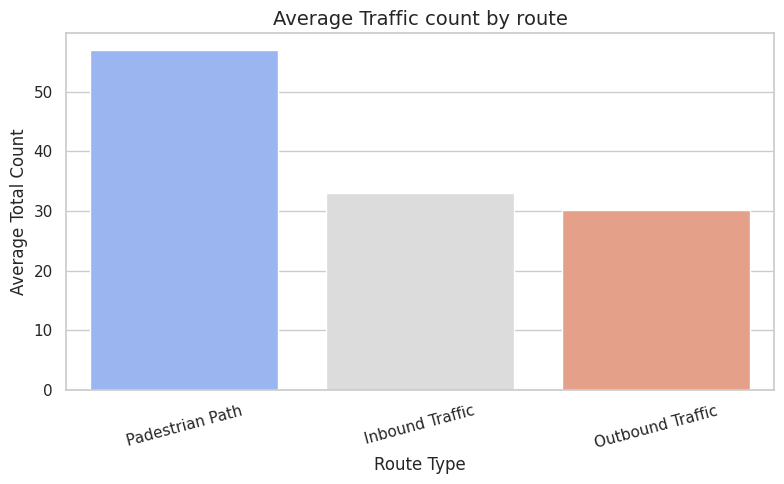

In [ ]:
# Traffic distribution by route
plt.figure(figsize=(8,5))
sns.barplot(x='name', y='total_count', data=df, estimator='mean', errorbar=None, hue='name', palette='coolwarm')
plt.title("Average Traffic count by route", fontsize=14)
plt.xlabel("Route Type")
plt.ylabel("Average Total Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

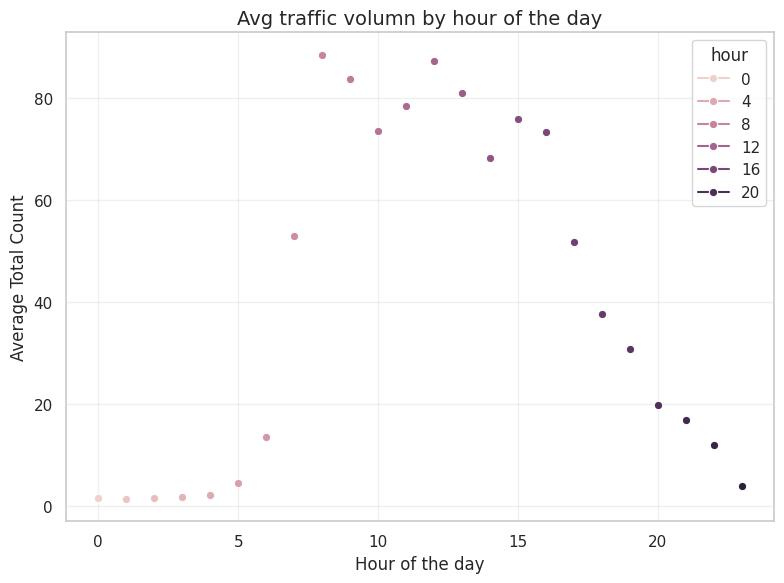

In [ ]:
#Hourly Traffic Pattern
plt.figure(figsize=(8,6))
sns.lineplot(x='hour', y='total_count', data=df, estimator='mean', errorbar=None, hue='hour', marker='o', color='teal')
plt.title("Avg traffic volumn by hour of the day", fontsize=14)
plt.xlabel("Hour of the day")
plt.ylabel("Average Total Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

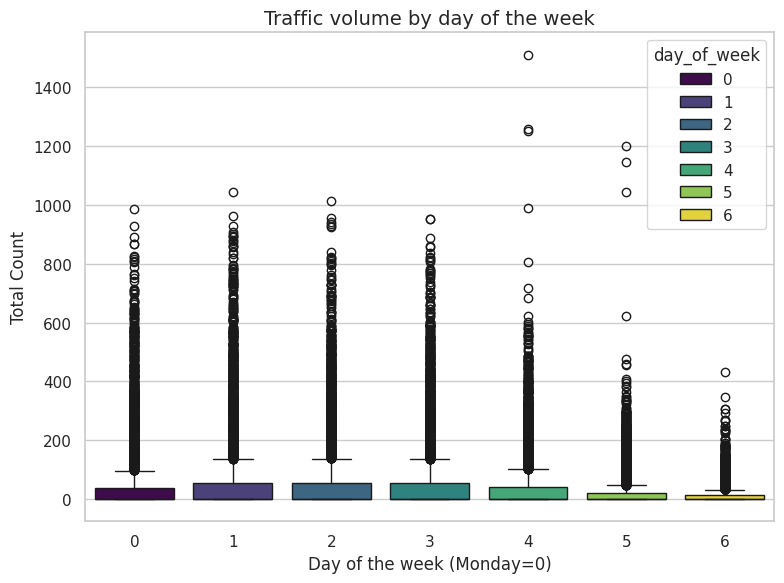

In [ ]:
#Weekly traffic trend
plt.figure(figsize=(8,6))
sns.boxplot(x='day_of_week', y='total_count', data=df, hue='day_of_week', palette='viridis')
plt.title("Traffic volume by day of the week", fontsize=14)
plt.xlabel("Day of the week (Monday=0)")
plt.ylabel("Total Count")
plt.tight_layout()
plt.show()

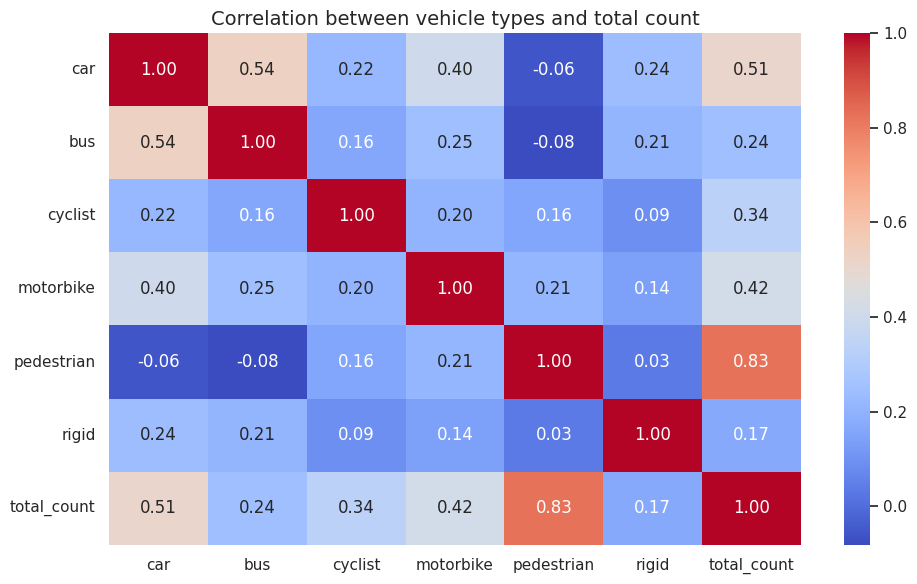

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,6))
corr = df[['car','bus','cyclist','motorbike','pedestrian','rigid','total_count']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between vehicle types and total count", fontsize=14)
plt.tight_layout()
plt.show()

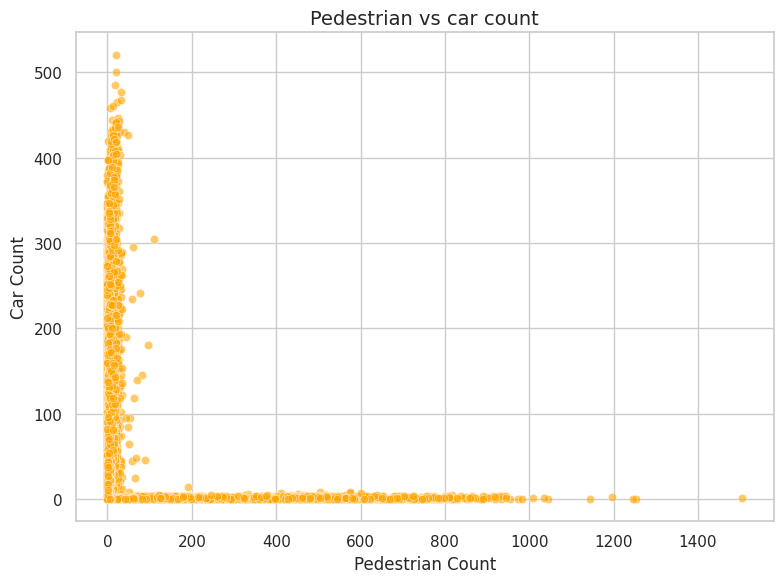

In [ ]:
#Pedestrian vs Car count
plt.figure(figsize=(8,6))
sns.scatterplot(x='pedestrian', y='car', data=df, alpha=0.6, color='orange')
plt.title("Pedestrian vs car count", fontsize=14)
plt.xlabel("Pedestrian Count")
plt.ylabel("Car Count")
plt.tight_layout()
plt.show()

2.6 Regression Model

In [ ]:
#import libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Load the dataset
X_train = pd.read_csv("/content/X_train.csv")
y_reg_train = pd.read_csv("/content/y_train.csv")
X_valid = pd.read_csv("/content/X_valid.csv")
y_reg_valid = pd.read_csv("/content/y_valid.csv")

#display shape
print("Traing data Shape:", X_train.shape)
print("Validation data Shape:", X_valid.shape)

Traing data Shape: (37190, 9)
Validation data Shape: (4649, 9)


In [ ]:
#Trainn the Linear Regression Model
model = LinearRegression()

#train the  model on training dataset
model.fit(X_train, y_reg_train)

print("Model training completed")

Model training completed


In [ ]:
#Make predictions on the validation set

#Predict using the validation inputs
y_reg_pred = model.predict(X_valid)

#Display first few predictions
print("Sample predictions:")
print(y_reg_pred[:10])

Sample predictions:
[[ 1.70000000e+01]
 [ 5.00000000e+00]
 [ 2.10984659e-14]
 [ 3.44040931e-14]
 [ 3.05734171e-15]
 [ 3.77462612e-14]
 [ 3.29351618e-14]
 [-7.82113093e-16]
 [ 4.68073995e-14]
 [ 5.00000000e+00]]


In [ ]:
#Evaluate the regression model
#Calculate evaluation metrics
mae = mean_absolute_error(y_reg_valid, y_reg_pred)
mse = mean_squared_error(y_reg_valid, y_reg_pred)
rmse = mse ** 0.5
r2 = r2_score(y_reg_valid, y_reg_pred)

print("Evaluation Results:")
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Evaluation Results:
Mean Absolute Error: 4.216010735568863e-14
Mean Squared Error: 4.880048562590804e-27
Root Mean Squared Error: 6.985734437115974e-14
R-squared: 1.0


2.7 Classification Model

In [ ]:
#Load data and create class labels
import pandas as pd
from sklearn.model_selection import train_test_split

#Load processed data
df = pd.read_csv("/content/traffic_Data_Processed.csv")

#Create a traffic-level label based on total_count
#Low: total_count<50 , Medium: 50 <= total_count < 200, High: total_count >=200

def traffic_level(x):
  if x < 50:
    return "Low"
  if x < 200:
    return "Medium"
  return "High"

df['traffic_level'] = df['total_count'].apply(traffic_level)

#Features and label
X = df[['route_code', 'hour', 'day_of_week', 'car', 'bus', 'cyclist', 'motorbike', 'pedestrian', 'rigid']]
y = df['traffic_level']

#Quick check
print("Class distribution:\n", y.value_counts())
print("Feature sample:")
display(X.head())

Class distribution:
 traffic_level
Low       36959
Medium     7053
High       2476
Name: count, dtype: int64
Feature sample:


,route_code,hour,day_of_week,car,bus,cyclist,motorbike,pedestrian,rigid
0,2,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,2,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0


In [ ]:
#Train/ Validation/test split
X_train, X_temp, y_cls_train, y_cls_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_valid, X_test, y_cls_valid, y_cls_test = train_test_split(X_temp, y_cls_temp, test_size=0.5, random_state=42, stratify=y_cls_temp)

print("Train:", X_train.shape, "Validation:", X_valid.shape, "Test:", X_temp.shape)
print("Train class counts:\n", y_cls_train.value_counts())

Train: (37190, 9) Validation: (4649, 9) Test: (9298, 9)
Train class counts:
 traffic_level
Low       29567
Medium     5642
High       1981
Name: count, dtype: int64


In [ ]:
#Train a decision tree classifier

from sklearn.tree import DecisionTreeClassifier

#create and train the classifier
clf = DecisionTreeClassifier(max_depth=6,random_state=42) #shallo tree for interpretability
clf.fit(X_train, y_cls_train)

print("Decision Tree trained. Depth limit:", clf.get_depth())

Decision Tree trained. Depth limit: 6


In [ ]:
#Predict on validation set
y_cls_val_pred = clf.predict(X_valid)

#Show a few predicted vs actual
val_smaple = pd.DataFrame({"actual": y_cls_valid.reset_index(drop=True), "predicted": pd.Series(y_cls_val_pred)})
display(val_smaple.head(10))

,actual,predicted
0,Low,Low
1,Low,Low
2,Low,Low
3,Medium,Medium
4,Low,Low
5,Low,Low
6,Low,Low
7,Low,Low
8,Low,Low
9,Low,Low


In [ ]:
#Evaluation matrics (validation)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

acc = accuracy_score(y_cls_valid, y_cls_val_pred)
pre, rec, f1, _ = precision_recall_fscore_support(y_cls_valid, y_cls_val_pred, average='weighted')
cm = confusion_matrix(y_cls_valid, y_cls_val_pred, labels=["Low","Medium", "High"])

print("Validation accuracy:",acc)
print("Weighted precision:",pre)
print("Weighted recall:",rec)
print("Weighted f1-score:",f1)
print("\nConfusion matrix (rows=true, cols=pred):\n", cm)
print("\nFull classification report:\n", classification_report(y_cls_valid, y_cls_val_pred))

Validation accuracy: 0.99247149924715
Weighted precision: 0.9924508093937171
Weighted recall: 0.99247149924715
Weighted f1-score: 0.9924546299385878

Confusion matrix (rows=true, cols=pred):
 [[3687    9    0]
 [  18  686    2]
 [   0    6  241]]

Full classification report:
               precision    recall  f1-score   support

        High       0.99      0.98      0.98       247
         Low       1.00      1.00      1.00      3696
      Medium       0.98      0.97      0.98       706

    accuracy                           0.99      4649
   macro avg       0.99      0.98      0.99      4649
weighted avg       0.99      0.99      0.99      4649



In [ ]:
#Final Evaluation on test set

y_cls_test_pred = clf.predict(X_test)
acc_test = accuracy_score(y_cls_test, y_cls_test_pred)
pre_test, rec_test, f1_test, _=precision_recall_fscore_support(y_cls_test, y_cls_test_pred, average='weighted')

print("Test accuracy:", acc_test)
print("Test Weighted precision:", pre_test)
print("Test Weighted recall:", rec_test)
print("Test Weighted f1-score:", f1)

Test accuracy: 0.9918261991826199
Test Weighted precision: 0.9918070827690912
Test Weighted recall: 0.9918261991826199
Test Weighted f1-score: 0.9924546299385878


2.8 Evaluate both Regression and Classification Model

In [93]:
#Displaying Evaluated Regression model
print("Regression Model Performance:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R2 Score:", r2)

#Classification Model
print("\nClassification Model Performance:")
print("Test accuracy:", acc_test)
print("Test Weighted precision:", pre_test)
print("Test Weighted recall:", rec_test)
print("Test Weighted f1-score:", f1)

Regression Model Performance:
Mean Absolute Error (MAE): 4.216010735568863e-14
Mean Squared Error (MSE): 4.880048562590804e-27
Root Mean Squared Error (RMSE): 6.985734437115974e-14
R2 Score: 1.0

Classification Model Performance:
Test accuracy: 0.9918261991826199
Test Weighted precision: 0.9918070827690912
Test Weighted recall: 0.9918261991826199
Test Weighted f1-score: 0.9924546299385878
